#Long Short-Term Memory for Sequential Predictions

Gage DeZoort\
3/25/24\
\
Based on several helpful tutorials:\
[1] [LSTM for Time Series Prediction in PyTorch](https://machinelearningmastery.com/lstm-for-time-series-prediction-in-pytorch/)\
[2] [Predicting airline passengers using LSTM and Tensorflow](https://matthewmacfarquhar.medium.com/predicting-airline-passengers-using-lstm-and-tensorflow-ab86347cf318)


## Temperature Predictions

This project is based on Long Short-Term Memory (LSTM) modules. LSTMs belong to the class of Recurent Neural Networks (RNNs), which operate on sequential data (ordered data, indexed by time or space). For example, the daily temperature is a time series we all experience:

![Weather](https://www.influxdata.com/wp-content/uploads/time-series-data-weather-data.png "weather")
(Image from [this article](https://www.influxdata.com/what-is-time-series-data/))

Sentences are another example of sequential data:

![Sentences](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*phpgEszN4Q6n_Rtd24zpGw.png "sentences")
(Image from [this article](https://bansalh944.medium.com/text-generation-using-lstm-b6ced8629b03))

We see that sequential data is everywhere! RNNs have accordingly bene applied to a wide variety of domains, including:

- Natural Language Processing (NLP): translation, word prediction, sentiment analysis
- Time-Series Analysis: financial predictions, weather/climate forecasting
- Music Generation: e.g. composition
- Robotics: e.g. path predictions

How do RNNs work? Here's a helpful diagram:

![RNN](https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/RNN-unrolled.png "rnn")
(Image from [this article](https://colah.github.io/posts/2015-08-Understanding-LSTMs/))

In this diagram, $A$ represents the NN. Here, we take $x_t$ to represent the sequence of inputs ($x_0$, $x_1$, $x_2$,...,$x_N$), and $h_t$ its sequence of outputs ($h_0$, $h_1$, $h_2$,...,$h_N$). The sequential nature of the predictions is highlight by the rightward arrows; the prediction at each timestep is informed by the prediction at the previous timestep. Unfortunately, it has been shown that simple RNNs *fail to learn long-term dependencies*. This was the motivation for developing LSTMs.

Okay, let's switch to a bit of coding.


In [1]:
import torch
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt

# grab data
!wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv

--2024-03-25 03:35:11--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2180 (2.1K) [text/plain]
Saving to: ‘airline-passengers.csv’

airline-passengers. 100%[===================>]   2.13K  --.-KB/s    in 0s      

2024-03-25 03:35:11 (15.0 MB/s) - ‘airline-passengers.csv’ saved [2180/2180]



## Dataset Preparation

In the last line, we grabed a CSV (comma-separated value) file called `airline-passengers.csv`. Let's use Pandas to explore the data.

In [2]:
df = pd.read_csv("airline-passengers.csv")
df.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


We see that this is a time-series, counting the number of passengers (in units of 1,000) between Jan. 1949 and Dec. 1960, corresponding to 12 years and 144 observations. Let's plot the trend:

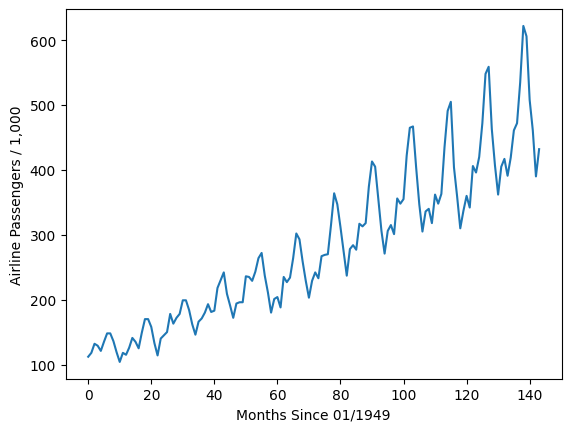

In [3]:
plt.plot(df.Passengers)
plt.xlabel("Months Since 01/1949")
plt.ylabel("Airline Passengers / 1,000")
plt.show()

What trends do you observe?

The upward trend will be difficult for the ML model to capture given the limited size of the dataset. We can simply remove it before training the algorithm, then add it back! Our goal will be to fit a quadratic to the data:

`P(m) = x_0 + x_1 * m + x_2 * m^2`

Where `P(m)` is the number of passengers in a given month `m`. Let's grab the regression coefficients:

In [4]:
N = len(df)
ones, xrange = np.ones(N), np.arange(N)
X = np.stack((ones, xrange, xrange**2)).T
y = df.Passengers.to_numpy().reshape(-1,1)
beta = (np.linalg.inv(X.T @ X)@X.T@y)
x0, x1, x2 = beta[0][0], beta[1][0], beta[2][0]
x0, x1, x2

(114.02804085970192, 1.6550115485861296, 0.007008198317901187)

Let's plot the corrected passengers data:

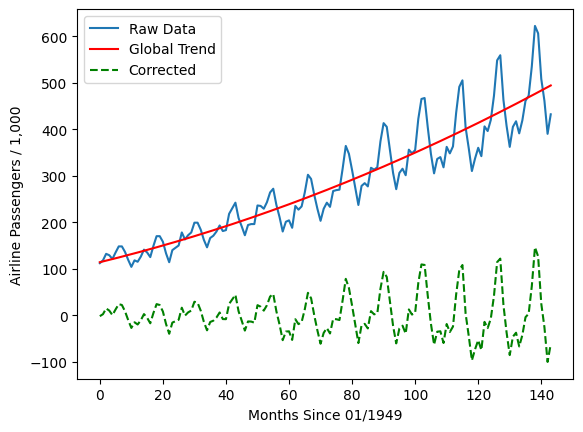

In [5]:
passengers = df.Passengers
plt.plot(passengers, label="Raw Data")

trend = x0 + xrange*x1 + xrange**2 * x2
passengers_c = passengers - trend

plt.plot(trend, "r-", label="Global Trend")
plt.plot(passengers_c, "g--", label="Corrected")
plt.xlabel("Months Since 01/1949")
plt.ylabel("Airline Passengers / 1,000")
plt.legend(loc="best")
plt.show()

## Building Train/Test Sets

In [6]:
# convert everything to plain arrays
passengers = passengers.values.astype("float32").reshape(-1,1)
passengers_c = passengers_c.values.astype("float32").reshape(-1,1)
passengers_c.shape

(144, 1)

Let's turn this into an ML task. Given 2/3 of the time series, can we predict the remaining 1/3? Fundamentally, that means we're doing regression.


In [7]:
# split into train/test
train_size = int(len(passengers_c)*0.67)
train, test = passengers_c[:train_size], passengers_c[train_size:]
train.shape, test.shape

((96, 1), (48, 1))

To train a model, we need to show it data in the time interval $[t-w, t-1]$, where $w$ is the window or "lookback" size, and ask it to make predictions for the timestep $t$. To do this, we need to turn our training data into $(X,y)$ pairs,  $X,y\in\mathbb{R}^{w}$, where $X$ reprsents the inputs and $y$ represents the targets.

In [8]:
def create_dataset(dataset, w=1):
    X,Y = [], []
    for i in range(len(dataset)-w-1):
        X.append(dataset[i:(i+w), 0])
        Y.append(dataset[i+w, 0])
    X, Y = torch.Tensor(X), torch.Tensor(Y)
    return X, Y.reshape(len(Y),1)

In [9]:
w = 3
X_train, y_train = create_dataset(train, w=w)
X_test, y_test = create_dataset(test, w=w)

<ipython-input-8-b3ec427c30c0>:6: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  X, Y = torch.Tensor(X), torch.Tensor(Y)


In [11]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([92, 3]),
 torch.Size([92, 1]),
 torch.Size([44, 3]),
 torch.Size([44, 1]))

## Building an LSTM
Now we're going to build a LSTM! Here's the PyTorch model:

In [12]:
import torch.nn as nn

class AirModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=w,
            hidden_size=64,
            num_layers=1,
            batch_first=False
          )
        self.linear1 = nn.Linear(
            in_features=64,
            out_features=1,
        )
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        x, _ = self.lstm(x)
        return self.linear1(x)

This model has several components. The main workhorse is the **LSTM Module**: see the [PyTorch docs](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html) for details of the implementation. Here's a diagram:

![LSTM](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*kT7TJdlJflJJSnEJ6XRKug.png "lstm")\
(Image from [this article](https://bansalh944.medium.com/text-generation-using-lstm-b6ced8629b03))
\
\
This is a single LSTM "block" corresponding to the timestep $t$. There's a lot going on here, but here's the gist:

- The LSTM block at timestep $t$ is fed by the input $x_t$ (# passengers), the output from the previous block $h_{t-1}$, and the memory from the previous block $c_{t-1}$.
- The LSTM block at timestep $t$ is composed of several logical gates. These include an input gate, a forget gate, a cell gate, and an output gate. The full system of equations is

$$
\begin{align*}
  i_t &= \sigma(W_{ii} x_t + b_{ii} + W_{hi}h_{t-1} + b_{hi})\ &\rightarrow \ \ \text{input gate} \\
  f_t &= \sigma(W_{if}x_t + b_{if} + W_{hf}h_{t-1} + b_{hf})\ &\rightarrow \ \ \text{forget gate}\\
  g_t &= \text{tanh}(W_{ig}x_t + b_{ig} + W_{hg}h_{t-1} + b_{hg})\ &\rightarrow \ \ \text{cell features}\\
  o_t &= \sigma(W_{io}x_t + b_{io} + W_{ho}h_{t-1} + b_{ho})\ &\rightarrow \ \ \text{output gate}\\
  c_t &= f_t \odot c_{t-1} + i_t \odot g_t\ &\rightarrow \ \ \text{cell state (memory)}\\
  h_t &= o_t \odot \text{tanh}(c_t) \ &\rightarrow \ \ \text{hidden state}
\end{align*}
$$

In practice, the PyTorch module `nn.LSTM()` has inputs `input_size` corresponding to the dimension of $x_t$, `hidden_size` corresponding to the size of the outputs $h_{t}$, and `num_layers` corresponding to the number of "stacked" LSTM modules. Let's train an our model:

In [13]:
import numpy as np
import torch.optim as optim
import torch.utils.data as data

model = AirModel()
optimizer = optim.Adam(model.parameters(), lr=10**-3)
loss_fn = nn.MSELoss()
loader = data.DataLoader(
    data.TensorDataset(X_train, y_train),
    shuffle=True,
    batch_size=8,
)

n_epochs = 1000
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 50 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

Epoch 0: train RMSE 30.0108, test RMSE 66.0789
Epoch 50: train RMSE 20.5005, test RMSE 53.7437
Epoch 100: train RMSE 16.7603, test RMSE 47.2982
Epoch 150: train RMSE 14.3146, test RMSE 43.6531
Epoch 200: train RMSE 12.5680, test RMSE 40.3545
Epoch 250: train RMSE 11.5102, test RMSE 38.3362
Epoch 300: train RMSE 10.6932, test RMSE 36.2945
Epoch 350: train RMSE 10.1779, test RMSE 35.2531
Epoch 400: train RMSE 9.2703, test RMSE 34.1950
Epoch 450: train RMSE 9.0729, test RMSE 34.0553
Epoch 500: train RMSE 8.4517, test RMSE 34.0909
Epoch 550: train RMSE 8.0733, test RMSE 33.4338
Epoch 600: train RMSE 7.2770, test RMSE 32.6592
Epoch 650: train RMSE 7.0637, test RMSE 32.7438
Epoch 700: train RMSE 6.4380, test RMSE 31.9052
Epoch 750: train RMSE 6.1883, test RMSE 33.0248
Epoch 800: train RMSE 6.0044, test RMSE 32.8669
Epoch 850: train RMSE 5.6208, test RMSE 32.2969
Epoch 900: train RMSE 5.3408, test RMSE 32.5869
Epoch 950: train RMSE 5.0427, test RMSE 32.3816


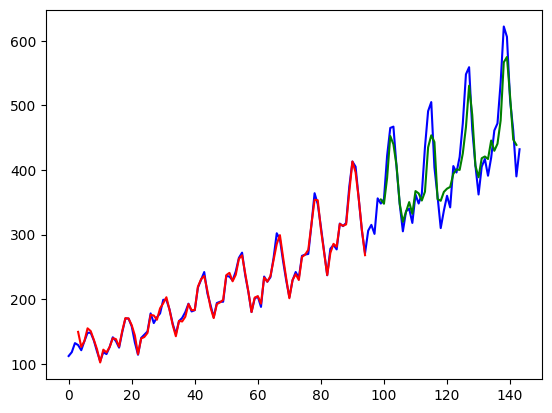

In [14]:
with torch.no_grad():
    train_plot = np.ones(len(passengers_c)) * np.nan
    train_plot[w:train_size-1] = model(X_train).flatten()
    test_plot = np.ones(len(passengers_c)) * np.nan
    test_plot[train_size+w:len(passengers_c)-1] = model(X_test).flatten()

plt.plot(passengers_c.flatten() + trend, c='b', label="Truth")
plt.plot(train_plot + trend, c='r', label="Training")
plt.plot(test_plot + trend, c='g', label="Predicted")
plt.show()


Clearly, the LSTM understands how to model the trends in the data, but is having issues capturing the magnitude of the seasonal fluctuations.

### Exercise 3
Can you improve the performance of the model? The full code from the notebook is reproduced below for your convenience. You may want to explore:

0) Add a second linear layer to the output of your network (see comments in the model below). \
1) Adjusting the learning rate.\
2) Increasing the size (# neurons, # layers) of the NN.\
3) Changing `w` (note that this alters the nature of the learning task, but may still be fun to explore).\
4) Changing the batch size.

Epoch 0: train RMSE 30.0225, test RMSE 66.0889
Epoch 50: train RMSE 21.0667, test RMSE 54.6669
Epoch 100: train RMSE 16.7837, test RMSE 47.3578
Epoch 150: train RMSE 14.3800, test RMSE 43.6292
Epoch 200: train RMSE 12.7225, test RMSE 40.8045
Epoch 250: train RMSE 11.7033, test RMSE 38.7681
Epoch 300: train RMSE 10.8640, test RMSE 37.1006
Epoch 350: train RMSE 10.1498, test RMSE 36.4830
Epoch 400: train RMSE 9.7374, test RMSE 35.6801
Epoch 450: train RMSE 9.1877, test RMSE 35.0087
Epoch 500: train RMSE 8.8981, test RMSE 35.1314
Epoch 550: train RMSE 8.3547, test RMSE 34.0790
Epoch 600: train RMSE 7.9078, test RMSE 33.8756
Epoch 650: train RMSE 7.4054, test RMSE 32.9145
Epoch 700: train RMSE 7.2883, test RMSE 33.8310
Epoch 750: train RMSE 7.0885, test RMSE 33.6259
Epoch 800: train RMSE 6.7688, test RMSE 32.9768
Epoch 850: train RMSE 6.3944, test RMSE 32.7372
Epoch 900: train RMSE 6.0204, test RMSE 32.7594
Epoch 950: train RMSE 5.7599, test RMSE 32.0362


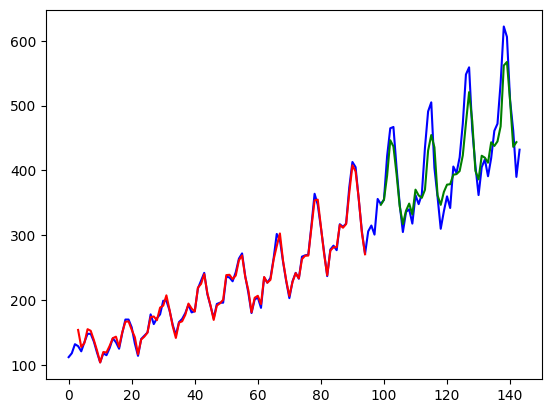

In [ ]:
import torch
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

df = pd.read_csv("airline-passengers.csv")

# fit the trend
N = len(df)
ones, xrange = np.ones(N), np.arange(N)
X = np.stack((ones, xrange, xrange**2)).T
y = df.Passengers.to_numpy().reshape(-1,1)
beta = (np.linalg.inv(X.T @ X)@X.T@y)
x0, x1, x2 = beta[0][0], beta[1][0], beta[2][0]

# convert everything to plain arrays
passengers = df.Passengers
trend = x0 + xrange*x1 + xrange**2 * x2
passengers_c = passengers - trend
passengers = passengers.values.astype("float32").reshape(-1,1)
passengers_c = passengers_c.values.astype("float32").reshape(-1,1)
passengers_c.shape

# split into train/test
train_size = int(len(passengers_c)*0.67)
train, test = passengers_c[:train_size], passengers_c[train_size:]
train.shape, test.shape

# define the model
class AirModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=w,
            hidden_size=64,
            num_layers=1,
            batch_first=False
          )
        self.linear1 = nn.Linear(
            in_features=64,
            out_features=1, #64,
        )
        #self.linear2 = nn.Linear(
        #    in_features=64,
        #    out_features=1,
        #)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        x, _ = self.lstm(x)
        return self.linear1(x)

model = AirModel()
optimizer = optim.Adam(model.parameters(), lr=10**-3)
loss_fn = nn.MSELoss()
loader = data.DataLoader(
    data.TensorDataset(X_train, y_train),
    shuffle=True,
    batch_size=8,
)

n_epochs = 1000
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 50 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

with torch.no_grad():
  train_plot = np.ones(len(passengers_c)) * np.nan
  train_plot[w:train_size-1] = model(X_train).flatten()
  test_plot = np.ones(len(passengers_c)) * np.nan
  test_plot[train_size+w:len(passengers_c)-1] = model(X_test).flatten()

plt.plot(passengers_c.flatten() + trend, c='b', label="Truth")
plt.plot(train_plot + trend, c='r', label="Training")
plt.plot(test_plot + trend, c='g', label="Predicted")
plt.show()